In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import TruncatedSVD
import warnings, joblib

warnings.filterwarnings('ignore')

In [4]:
train_df = pd.read_csv("./Data/train_clean.csv")
valid_df = pd.read_csv("./Data/valid_clean.csv")

In [5]:
X_train = train_df.drop(columns=["ID", "Label"])
y_train = train_df["Label"]

X_valid = valid_df.drop(columns=["ID", "Label"])
y_valid = valid_df["Label"]

In [6]:
def create_advanced_features(df):
    df = df.copy()
    
    df['sentence_count'] = df['Statement'].apply(lambda x: len(str(x).split('.')))
    df['exclamation_count'] = df['Statement'].apply(lambda x: str(x).count('!'))
    df['question_count'] = df['Statement'].apply(lambda x: str(x).count('?'))
    df['uppercase_ratio'] = df['Statement'].apply(
        lambda x: sum(1 for c in str(x) if c.isupper()) / max(len(str(x)), 1)
    )
    
    df['avg_sentence_length'] = df['word_count'] / df['sentence_count'].replace(0, 1)
    df['complex_word_ratio'] = df['Statement'].apply(
        lambda x: sum(1 for word in str(x).split() if len(word) > 6) / max(len(str(x).split()), 1)
    )
    
    return df

print("Creating advanced features...")
X_train = create_advanced_features(X_train)
X_valid = create_advanced_features(X_valid)

text_col = "Statement"
cat_cols = ["Party Affiliation", "Speaker Job Title", "State Info"]
num_cols = [
    "char_count", "word_count", "avg_word_length", "true_ratio", "false_ratio",
    "sentence_count", "exclamation_count", "question_count", "uppercase_ratio",
    "avg_sentence_length", "complex_word_ratio"
]

Creating advanced features...


In [7]:
text_transformer_alt = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 3),  
        min_df=3,
        max_df=0.8,
        stop_words='english',
        sublinear_tf=True, 
        use_idf=True
    )),
    ('svd', TruncatedSVD(n_components=500, random_state=42))  
])

text_transformer = TfidfVectorizer(
    max_features=4000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.9,
    stop_words='english',
    analyzer='word',
    sublinear_tf=True
)

cat_transformer = OneHotEncoder(handle_unknown="ignore")

num_transformer = StandardScaler()


preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, text_col),
        ("cat", cat_transformer, cat_cols),
        ("num", num_transformer, num_cols)
    ],
    remainder='drop'
)

In [8]:
gradient_boosting_model = Pipeline([
    ("preprocess", preprocessor),
    ("gb", GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.05,        
        max_depth=2,                
        min_samples_split=100,    
        min_samples_leaf=50,        
        subsample=0.6,             
        max_features='sqrt',      
        random_state=42,
        validation_fraction=0.1,    
        n_iter_no_change=5,       
        tol=1e-4                   
    ))
])

In [9]:
param_grid = {
    'gb__n_estimators': [500],
    'gb__learning_rate': [0.1, 0.2],
    'gb__max_depth': [3, 4, 5],
    'gb__min_samples_split': [50, 100],
    'gb__min_samples_leaf': [30, 50],
    'gb__subsample': [0.7, 0.8, 0.9],
    'gb__max_features': ['sqrt', 0.3]
}

grid_search = GridSearchCV(
    gradient_boosting_model, 
    param_grid, 
    cv=5,  
    scoring='f1_macro', 
    n_jobs=-1,
    verbose=1
)

In [10]:
print("Training Gradient Boosting model...")
gradient_boosting_model.fit(X_train, y_train)
print("Training completed!")

Training Gradient Boosting model...
Training completed!


In [11]:
y_train_pred = gradient_boosting_model.predict(X_train)

print("Training Results:")
print(classification_report(y_train, y_train_pred))
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

Training Results:
              precision    recall  f1-score   support

 barely-true       0.42      0.01      0.02      1654
       false       0.34      0.60      0.43      1995
   half-true       0.31      0.63      0.41      2114
 mostly-true       0.47      0.55      0.51      1962
  pants-fire       0.00      0.00      0.00       839
        true       0.60      0.03      0.05      1676

    accuracy                           0.36     10240
   macro avg       0.36      0.30      0.24     10240
weighted avg       0.39      0.36      0.28     10240

Training Accuracy: 0.3572265625


In [12]:
y_valid_pred = gradient_boosting_model.predict(X_valid)

print("Validation Results:")
print(classification_report(y_valid, y_valid_pred))
print("Validation Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("Macro F1 Score:", f1_score(y_valid, y_valid_pred, average='macro'))

Validation Results:
              precision    recall  f1-score   support

 barely-true       0.00      0.00      0.00       237
       false       0.34      0.60      0.44       263
   half-true       0.27      0.58      0.37       248
 mostly-true       0.49      0.55      0.52       251
  pants-fire       0.00      0.00      0.00       116
        true       0.33      0.01      0.02       169

    accuracy                           0.35      1284
   macro avg       0.24      0.29      0.22      1284
weighted avg       0.26      0.35      0.27      1284

Validation Accuracy: 0.34501557632398755
Macro F1 Score: 0.22483720207301092


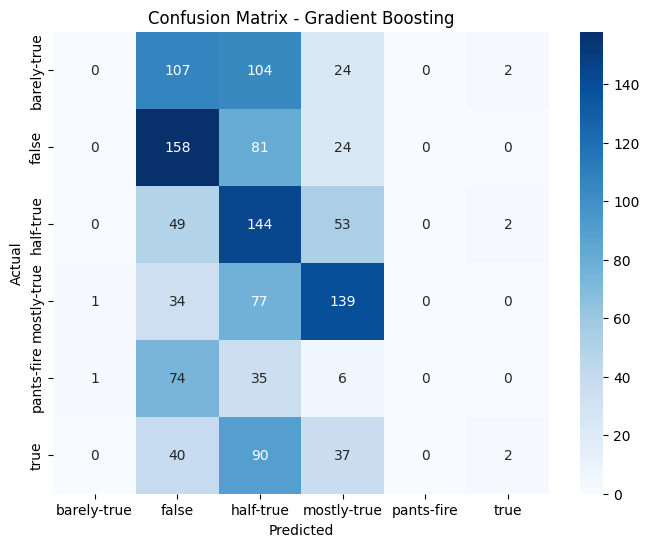

In [13]:
cm = confusion_matrix(y_valid, y_valid_pred, labels=gradient_boosting_model.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=gradient_boosting_model.classes_, yticklabels=gradient_boosting_model.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()

In [14]:
print("\n=== MODEL SUMMARY ===")
print("Model: gradient_boosting")
print("Preprocessing: basic")
print("Vectorizer: tfidf_standard")
print("Training Accuracy:", round(accuracy_score(y_train, y_train_pred), 4))
print("Validation Accuracy:", round(accuracy_score(y_valid, y_valid_pred), 4))
print("F1 Macro Score:", round(f1_score(y_valid, y_valid_pred, average='macro'), 4))


=== MODEL SUMMARY ===
Model: gradient_boosting
Preprocessing: basic
Vectorizer: tfidf_standard
Training Accuracy: 0.3572
Validation Accuracy: 0.345
F1 Macro Score: 0.2248


In [ ]:
# joblib.dump(gradient_boosting_model, 'gradient_boosting_model.joblib')

['gradient_boosting_model.joblib']

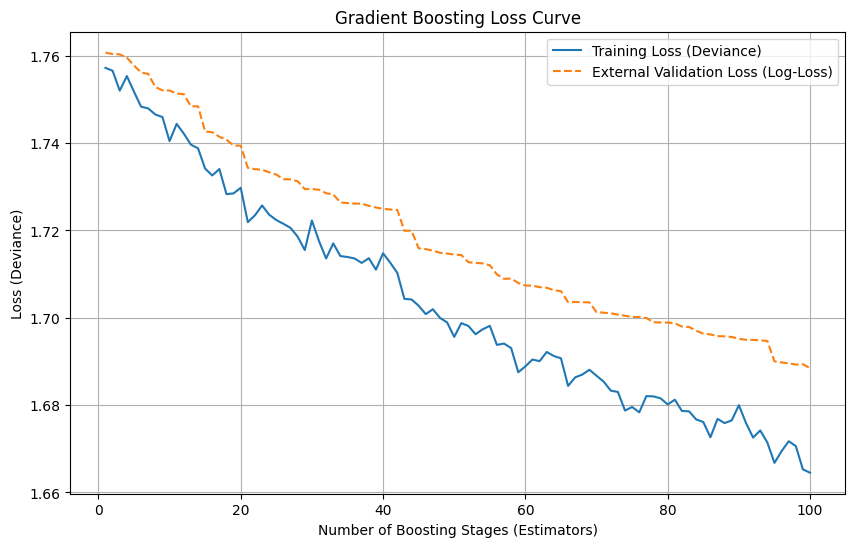

In [17]:
# Make sure to import log_loss if you haven't already:
# from sklearn.metrics import log_loss
from sklearn.metrics import log_loss

# 1. Get the GradientBoostingClassifier estimator from the pipeline
gb_estimator = gradient_boosting_model['gb']

# 2. Transform the external validation data (X_valid) using the pipeline's preprocessor
# We must transform X_valid before passing it to the raw gb_estimator
X_valid_transformed = gradient_boosting_model['preprocess'].transform(X_valid)

# 3. Calculate the external validation loss (Log-Loss/Deviance) at each stage
validation_loss = []
for y_pred_proba_stage in gb_estimator.staged_predict_proba(X_valid_transformed):
    # Log loss is the loss function (deviance) for multi-class classification
    loss = log_loss(y_valid, y_pred_proba_stage)
    validation_loss.append(loss)

# 4. Plot the curves
n_estimators = len(gb_estimator.estimators_)
plt.figure(figsize=(10, 6))

# Plot training deviance (this attribute is correctly populated)
plt.plot(np.arange(n_estimators) + 1, gb_estimator.train_score_, label='Training Loss (Deviance)')

# Plot the calculated external validation deviance
plt.plot(np.arange(n_estimators) + 1, validation_loss, label='External Validation Loss (Log-Loss)', linestyle='--')

plt.xlabel('Number of Boosting Stages (Estimators)')
plt.ylabel('Loss (Deviance)')
plt.title('Gradient Boosting Loss Curve')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()